In [34]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [36]:
training_file = path.join('semeval2016-task6-trainingdata.txt')
training_data = pd.read_csv(training_file, header=0, delimiter='\t')

In [37]:
testing_file = path.join('SemEval2016-Task6-subtaskA-testdata-gold.txt')
testing_data = pd.read_csv(testing_file,header=0, delimiter='\t')

In [38]:
def preprocess(text):
    #convert text to lower case
    text = text.lower()
   
    #removing whitespace
    text.strip()

    #removing digits
    text = gensim.parsing.preprocessing.strip_numeric(text)
    #text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
    
    #remove stopwords
    text = gensim.parsing.preprocessing.remove_stopwords(text)
    
    #strip punctutation
    text = gensim.parsing.preprocessing.strip_punctuation(text)
    
    #strip multiple whitepsace that might occur after we remove stopwords
    text = gensim.parsing.preprocessing.strip_multiple_whitespaces(text)

    p = PorterStemmer()
    
    text = ' '.join(p.stem(word) for word in text.split())    

    #print(text)
    
    return text

In [39]:
training_data['Tweet'] = training_data['Tweet'].map(preprocess)

In [40]:
testing_data['Tweet'] = testing_data['Tweet'].map(preprocess)

In [41]:
training_data = training_data[training_data.Target == "Legalization of Abortion"]
testing_data = testing_data[testing_data.Target== "Legalization of Abortion"]

In [42]:
X_train = training_data["Tweet"]

In [43]:
X_train = np.asarray([stance for stance in training_data["Tweet"]])

In [44]:
Y_train = np.asarray([stance for stance in training_data["Stance"]])

In [45]:
X_test = np.asarray([stance for stance in testing_data["Tweet"]])

In [46]:
Y_test = np.asarray([stance for stance in testing_data["Stance"]])

In [47]:
type(Y_train)

numpy.ndarray

In [48]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [49]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_train.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_training = X_train[training_indices]
y_training = Y_train[training_indices]

In [50]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_train,training_indices,axis=0)
y_pool = np.delete(Y_train,training_indices,axis=0)

In [51]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, 
                              binary=True, norm='l2', use_idf=True, 
                              smooth_idf=False, sublinear_tf=True, encoding='latin1')

In [52]:
X_training = vectorizer.fit_transform(X_training)
X_testing = vectorizer.transform(X_test)
X_pool_tifd = vectorizer.transform(X_pool)

In [53]:
y_pool = np.asarray([stance for stance in y_pool])

In [54]:
X_pool_tifd = X_pool_tifd.todense()

In [55]:
X_pool_tifd = np.asarray(X_pool_tifd)

In [56]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)

In [57]:
def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)

# uncertainty_sampling

In [58]:
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from modAL.uncertainty import uncertainty_sampling
# initializing the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_training, y_training=y_training,
    query_strategy=uncertainty_sampling
)


In [59]:
unqueried_score = learner.score(X_testing, Y_test)

In [60]:
unqueried_score

0.17142857142857143

In [61]:
type(y_pool[100].reshape(1, ))

numpy.ndarray

In [63]:
N_QUERIES = 30
performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool_tifd,n_instances = 20)
    X = X_pool[query_index]
    X = vectorizer.transform(X)
    y = y_pool[query_index]
    learner.teach(X=X,y=y)
    X_pool_tifd = np.delete(X_pool_tifd,query_index,axis=0)
    y_pool = np.delete(y_pool,query_index,axis=0)
    model_accuracy = learner.score(X_testing, Y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.6571
Accuracy after query 2: 0.5571
Accuracy after query 3: 0.5750
Accuracy after query 4: 0.6679
Accuracy after query 5: 0.6607
Accuracy after query 6: 0.6643
Accuracy after query 7: 0.6607
Accuracy after query 8: 0.6714
Accuracy after query 9: 0.6429
Accuracy after query 10: 0.6464
Accuracy after query 11: 0.6536
Accuracy after query 12: 0.6679
Accuracy after query 13: 0.6536
Accuracy after query 14: 0.6679
Accuracy after query 15: 0.6357
Accuracy after query 16: 0.6429
Accuracy after query 17: 0.6536
Accuracy after query 18: 0.6571
Accuracy after query 19: 0.6429
Accuracy after query 20: 0.6357
Accuracy after query 21: 0.6393
Accuracy after query 22: 0.6500
Accuracy after query 23: 0.6571
Accuracy after query 24: 0.6571
Accuracy after query 25: 0.6464
Accuracy after query 26: 0.6607
Accuracy after query 27: 0.6500
Accuracy after query 28: 0.6607
Accuracy after query 29: 0.6607
Accuracy after query 30: 0.6607


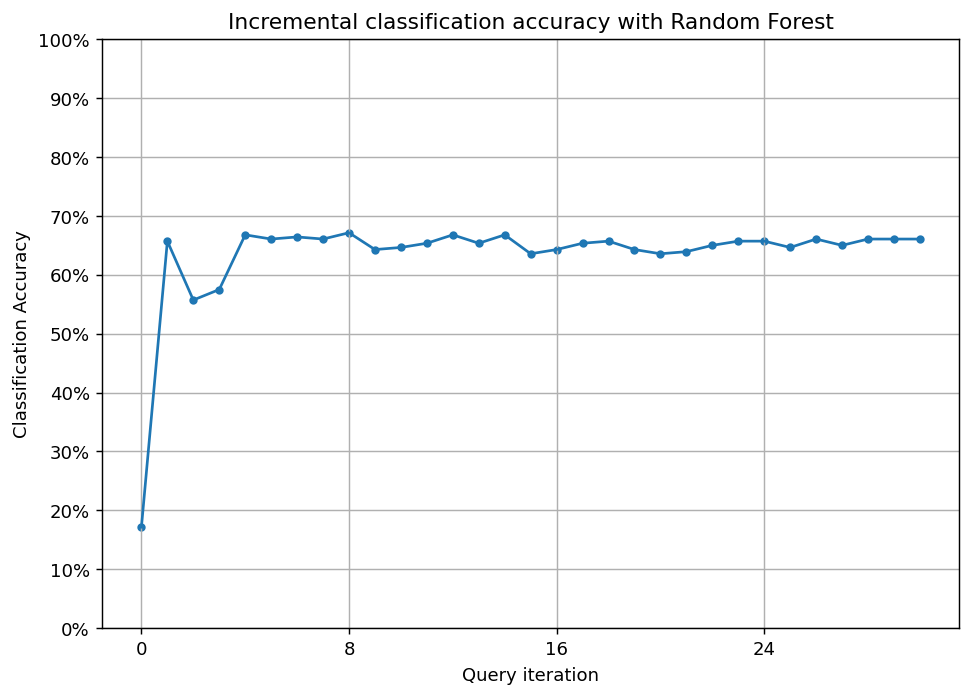

In [66]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy with Random Forest')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [67]:
fig.savefig('RF_fig.jpg')

# ranked batch mode sampling

In [ ]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_train.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_training_ = X_train[training_indices]
y_training_ = Y_train[training_indices]

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=RandomForestClassifier(),

  X_training=X_training,
  y_training=y_training,

  query_strategy=preset_batch
)

In [ ]:
unqueried_score = learner.score(X_testing, Y_test)
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool_tifd)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool_tifd[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool_tifd = np.delete(X_pool_tifd, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_testing, Y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)